# MLB Model Optimization
> Part 4 - Solidly outperforming the casinos after hyperparameter optimization & more data

- toc: false
- badges: true
- comments: true
- categories: [baseball, hyperopt, xgboost]
- image: images/chart-preview.png

In [1]:
#hide
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


In Part 3, our model was already performing better than the casino's oddsmakers, but it was only 0.6% better in accuracy and calibration was at parity. In this notebook, we'll get those numbers higher by doing some optimization of the hyperparameters and getting more data.

## Get More Data
This is key to solving the overfitting problem we saw in Part 3. XGBoost wanting a low `max_depth` feels like a big deal to me, so let's solve it. I think of overfitting as a problem of either too many features or not enough data. I really love all the fancy and clever features we've made, so let's get more data.

Start by going back to the blog post for Part 2 and run the whole thing again, except when you download from baseball-reference.com, start in 2013 instead fo 2016. The code to change is right under the header "Create List of Games to Download". It might take a bit to download all that data.

... I'll wait ...

Then re-run Part 3 to add the odds and power rankings to the dataset.

... Go on ...

Done? Great. Let's get that new dataframe you saved into this notebook. Now we'll prepare it to be run by XGBoost in the same way we did in the last post, except that we're going to increase the size of the validation set from 500 games to 2500 games - a whole season of games.

In [2]:
import pickle
df = pickle.load(open('dataframe_part3_big.pkl','rb'))

# target encoding
encode_me = [x for x in df.keys() if 'object' in str(df[x].dtype)]
for x in encode_me:
    df[x] = df.groupby(x)['home_team_win'].apply(lambda x:x.rolling(180).mean()).shift(1)

# create test, train splits
df = df.sort_values(by='date').copy().reset_index(drop=True)
X = df.drop(columns=['home_team_win', 'game_id'])
y = df.home_team_win

X_train = X[:-2500]
y_train = y[:-2500]
X_valid = X[-2500:-500]
y_valid = y[-2500:-500]
X_test = X[-500:]
y_test = y[-500:]

## Hyperparameter Optimization
For this post we'll use Hyperopt, a Baysean hyperparameter optimization tool. This will perform a search of the different parameters that we'll be feeding XGBoost to see which perform best. You can read on [their website](https://hyperopt.github.io/hyperopt/) about how it works.

Install it like this
``` pip install hyperopt ```

Below are the 3 functions I use to optimize XGBoost. The `get_xgb_model` function just trains the model, `xgb_objective` calls the first and does the model scoring, and `get_xgbparams` is the function that starts the hyperopt magic.

In [3]:
from hyperopt import fmin, tpe, hp, Trials
import xgboost as xgb
from sklearn.metrics import accuracy_score, brier_score_loss

def get_xgb_model(params):
    # comment the next 2 lines out if you don't have gpu
    params['gpu_id'] = 0
    params['tree_method'] = 'gpu_hist'
    params['seed']=13

    gbm = xgb.XGBClassifier(**params,n_estimators=999)
    model = gbm.fit(X_train, y_train,
                    verbose=False,
                    eval_set = [[X_train, y_train],
                              [X_valid, y_valid]],
                    eval_metric='logloss',
                    early_stopping_rounds=15)
    return model

def xgb_objective(params):
    params['max_depth']=int(params['max_depth'])
    model = get_xgb_model(params)
    xgb_test_proba = model.predict_proba(X_valid)[:,1]
    score = brier_score_loss(y_valid, xgb_test_proba)
    return(score)

trials = Trials() # recorder for our results

def get_xgbparams(space, evals=15):
    params = fmin(xgb_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=evals,
        trials=trials)
    params['max_depth']=int(params['max_depth'])
    return params

Next we define the search space for hpyperopt and start the run. I won't go into the function of each of the hyperparameters, but I will give a shout out to [this blog post](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) - it's one of the best resources I've seen on the subject. Most of the time I get good results in 250 runs, but if I'm feeling thorough (and patient) I let it run for 2000 iterations. The space below could represent a million significantly different parameter combinations, so 250 trials might be putting too much faith in the search algorithm.

Let's do 1000 iterations and see what happens.

In [4]:
import numpy as np
hyperopt_runs = 1000

space = {
    'max_depth':  hp.quniform('max_depth', 1, 8, 1),
    'min_child_weight': hp.quniform('min_child_weight', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(.01),np.log(.1)),
    'subsample': hp.quniform('subsample', 0.2, 1.0,.2),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.2, 1.0,.2),
    'reg_alpha': hp.loguniform('reg_alpha',np.log(1e-2),np.log(1e2))
}
xgb_params = get_xgbparams(space,hyperopt_runs)
xgb_params

100%|██████████| 1000/1000 [2:55:11<00:00, 10.51s/trial, best loss: 0.23426732326634775] 


{'colsample_bytree': 0.8,
 'learning_rate': 0.03134186616692019,
 'max_depth': 6,
 'min_child_weight': 14.0,
 'reg_alpha': 0.706883432815561,
 'subsample': 0.4}

We just spent long time optimizing to the validation set and we found a very good set of parameters for it. That doesn't mean it's going to work well for the test set. But we'll cross our fingers anyway.

Casino		Accuracy:0.5840	 Brier Loss: 0.2398
XGBoost		Accuracy:0.5740	 Brier Loss: 0.2447


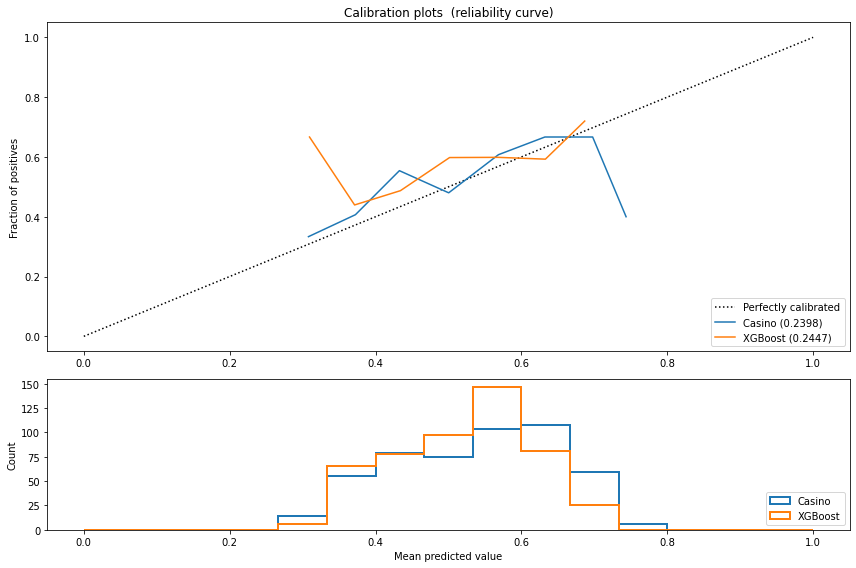

In [6]:
#collapse-hide
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, brier_score_loss
import matplotlib.pyplot as plt
import pickle

def cal_curve(data, bins):
    # adapted from:
    #https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    fig = plt.figure(1, figsize=(12, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for y_test, y_pred, y_proba, name in data:
        brier = brier_score_loss(y_test, y_proba)
        print("{}\t\tAccuracy:{:.4f}\t Brier Loss: {:.4f}".format(
            name, accuracy_score(y_test, y_pred), brier))
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, y_proba, n_bins=bins)
        ax1.plot(mean_predicted_value, fraction_of_positives,
                 label="%s (%1.4f)" % (name, brier))
        ax2.hist(y_proba, range=(0, 1), bins=bins, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

model = get_xgb_model(xgb_params)
xgb_test_preds = model.predict(X_test)
xgb_test_proba = model.predict_proba(X_test)[:,1]

casino_proba = X_test['odds_proba']
casino_preds = X_test['odds_proba']>.5

data = [
    (y_test, casino_preds, casino_proba, 'Casino'),
    (y_test,xgb_test_preds, xgb_test_proba, 'XGBoost')
]
cal_curve(data, 15)

Well that's not better. Even though our validation set had a `brier_score_loss` of 0.234, when we tried the same parameters on test it scores 0.247 - 5.6% worse. Let's print out our top hyperopt runs and see if the top one is an aberration.

In [7]:
import pandas as pd
results = []
for i in range(len(trials.trials)):
    trial = trials.trials[i]
    inputs = trial['misc']['vals']
    d = {}
    for key in inputs.keys():
        d[key]=inputs[key][0]
    d['loss'] = trials.losses()[i]
    results.append(d)
pd.DataFrame(results).sort_values(by='loss')[:15]

,colsample_bytree,learning_rate,max_depth,min_child_weight,reg_alpha,subsample,loss
545,0.8,0.031342,6.0,14.0,0.706883,0.4,0.234267
803,0.8,0.024690,7.0,11.0,0.227800,0.6,0.234566
739,0.8,0.028251,7.0,12.0,0.828374,0.6,0.234669
560,0.6,0.025124,6.0,12.0,0.524683,0.2,0.234754
318,1.0,0.041507,7.0,7.0,5.616624,0.6,0.234871
785,0.8,0.026125,7.0,11.0,0.336314,0.6,0.234902
428,0.6,0.088649,3.0,10.0,2.052890,0.6,0.234911
14,0.8,0.056913,7.0,11.0,11.230814,0.6,0.234926
630,0.8,0.022215,7.0,12.0,8.019199,0.6,0.235049
920,0.8,0.020671,7.0,9.0,1.259780,0.4,0.235057


It does look like our best run is an outlier, at least for `min_child_weight`. Let's take these insights and try to find a combination that translates to our test set.

Casino		Accuracy:0.5840	 Brier Loss: 0.2398
XGBoost		Accuracy:0.6060	 Brier Loss: 0.2383


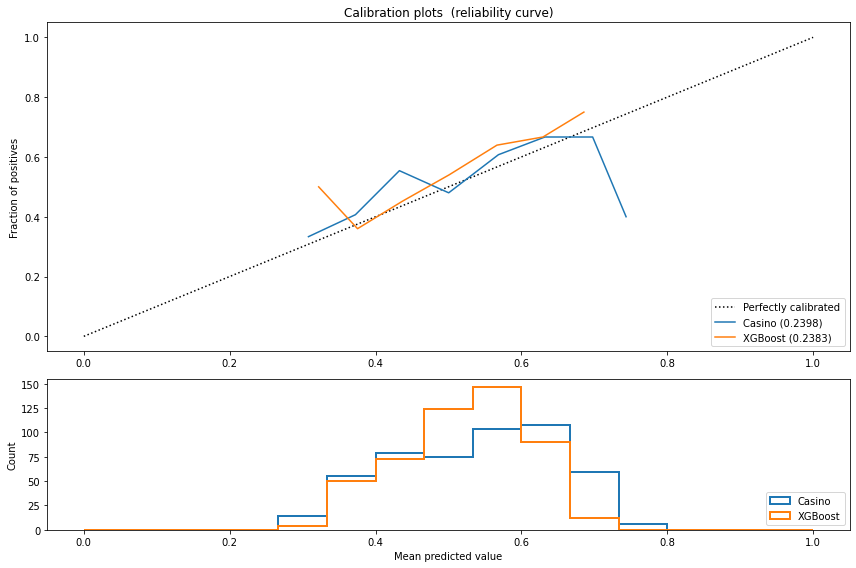

In [70]:
params = {
    'colsample_bytree':.7,
    'learning_rate':.03,
    'max_depth':7,
    'min_child_weight':11,
    'reg_alpha':0,
    'subsample':.25
}
model = get_xgb_model(params)
xgb_test_preds = model.predict(X_test)
xgb_test_proba = model.predict_proba(X_test)[:,1]

casino_proba = X_test['odds_proba']
casino_preds = X_test['odds_proba']>.5

data = [
    (y_test, casino_preds, casino_proba, 'Casino'),
    (y_test,xgb_test_preds, xgb_test_proba, 'XGBoost')
]
cal_curve(data, 15)

I get pretty obsessive about hyperparameter adjustments. It's like a little game that I can't stop playing. I am just going to stop. This is good.

 We've got a model that >2% better than the casino's and just as well calibrated. The last thing I want to check is how closely our predictions are correlated to the casino's. The lower the correlation, the more bets we'll get to place.

In [71]:
from sklearn.metrics import r2_score
r2_score(casino_proba, xgb_test_proba)

0.681159153310547

That's great news. It looks like it's going to give us a lot of opportunities to bet. Let's save our model. We'll use it in Part 5.

In [72]:
import pickle
pickle.dump(model,open('xgb_model.pkl','wb'))

## Next Up
Part 5. Time move on to figuring out how to generate predictions and place bets. We'll use the [Kelly criterion](https://en.wikipedia.org/wiki/Kelly_criterion).